In [1]:
# Install required libs
%pip install -U segmentation_models_pytorch albumentations --user --quiet


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: /Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Install required libs
%pip install -U albumentations --user --quiet


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: /Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Loading data

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive, files
if not os.path.exists('/content/drive'):
  drive.mount('/content/drive')

In [5]:
#DATA_DIR = '/content/data_colab/food'
DATA_DIR = './data_colab/food/'

#if not os.path.exists(DATA_DIR):
#files.upload()

In [6]:
if not os.path.exists(DATA_DIR):
  !unzip /content/drive/MyDrive/Be.ai/data_colab.zip # to /content/data

In [7]:
x_train_dir = os.path.join(DATA_DIR, 'train/img')
y_train_dir = os.path.join(DATA_DIR, 'train/masks_machine')
y_train_human_dir = os.path.join(DATA_DIR, 'train/masks_human')


x_valid_dir = os.path.join(DATA_DIR, 'valid/img')
y_valid_dir = os.path.join(DATA_DIR, 'valid/masks_machine')
y_valid_human_dir = os.path.join(DATA_DIR, 'valid/masks_human')

x_test_dir = os.path.join(DATA_DIR, 'test/img')
y_test_dir = os.path.join(DATA_DIR, 'test/masks_machine')
y_test_human_dir = os.path.join(DATA_DIR, 'test/masks_human')

In [8]:
# helper function for data visualization
import matplotlib.pyplot as plt
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

# testing images

In [9]:
image = cv2.imread('./data_colab/food/train/img/3c8d37a5-f683-4ee9-aacf-1cf916060c5f.jpg', cv2.IMREAD_COLOR)
mask = cv2.imread('./data_colab/food/train/masks_machine/3c8d37a5-f683-4ee9-aacf-1cf916060c5f.png', cv2.IMREAD_UNCHANGED)
human_mask = cv2.imread('./data_colab/food/train/masks_human/3c8d37a5-f683-4ee9-aacf-1cf916060c5f.png', cv2.IMREAD_COLOR)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
human_mask = cv2.cvtColor(human_mask, cv2.COLOR_BGR2RGB)

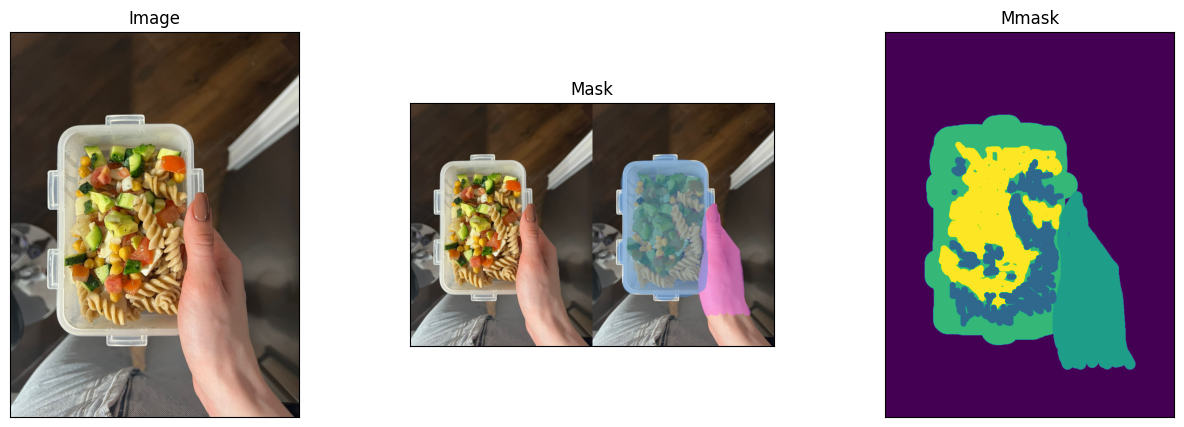

In [10]:
visualize(image=image,mask=human_mask, mmask=mask)

In [11]:
mask.shape

(1600, 1200)

# Dataloader

In [12]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [13]:
class Dataset(BaseDataset):
    """Food Dataset. Read images, apply augmentation and preprocessing transformations.

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. noralization, shape manipulation, etc.)

    """

    CLASSES = ['proteins', 'cellulose', 'carbohydrates', 'plate', 'palm',
               'container', 'fats', 'soup', 'salad', 'unlabelled']

    def __init__(
            self,
            images_dir,
            masks_dir,
            classes=None,
            augmentation=None,
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        # we need this crutch for .ds_store files
        self.ids = [i for i in self.ids if self.get_file_extension(images_dir, i,) == '.jpg']
        self.mask_ids = [self.get_mask_name(images_dir, i, ".png") for i in self.ids if self.get_file_extension(images_dir, i,) == '.jpg']
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, mask_id) for mask_id in self.mask_ids]

        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]

        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask_img = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED)

        # extract certain classes from mask (e.g. cars)
        masks = [(mask_img == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.ids)


    def get_mask_name(self, img_path, img, file_extension = ".png"):
      mask_filename = os.path.splitext(os.path.basename(os.path.join(img_path, img)))[0]
      mask = mask_filename.join(["", file_extension])
      return mask

    def get_file_extension(self, img_path, img):
      if os.path.splitext(os.path.basename(os.path.join(img_path, img)))[1]:
            return os.path.splitext(os.path.basename(os.path.join(img_path, img)))[1]
      return ''


float64
(1600, 1200, 10)


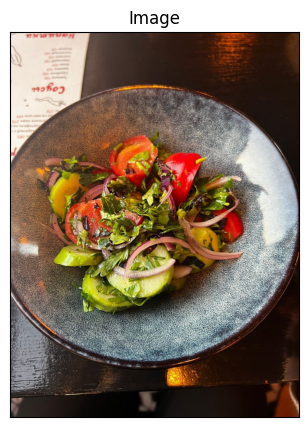

In [14]:
# Lets look at data we have
CLASSES = ['proteins', 'cellulose', 'carbohydrates', 'plate', 'palm',
               'container', 'fats', 'soup', 'salad', 'unlabelled']

dataset = Dataset(x_train_dir, y_train_dir, classes=CLASSES)

image, mask = dataset[4] # get some sample

print(mask.dtype)
print(mask.shape)
visualize(
    image=image,
)

# Augmentations

In [15]:
import albumentations as albu

In [16]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0, value=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.GaussNoise(p=0.2),
        albu.Perspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightnessContrast(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                # albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomBrightnessContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(1600, 1216)
    ]
    return albu.Compose(test_transform)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform

    Args:
        preprocessing_fn (callbale): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose

    """

    img_size = 512
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.LongestMaxSize(img_size),          # unify size
        albu.Normalize(),                       # normalize
        albu.PadIfNeeded(img_size, img_size),   # W = H
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

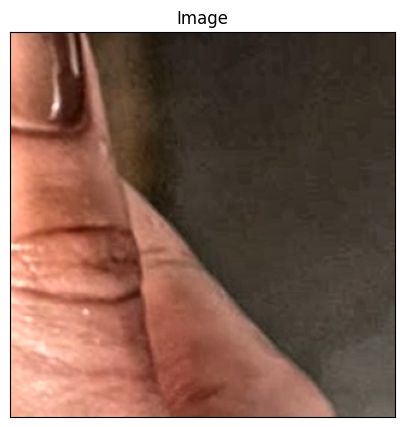

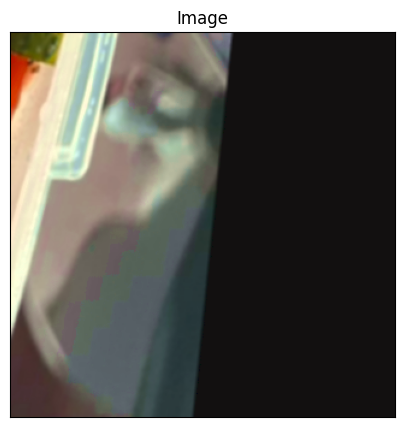

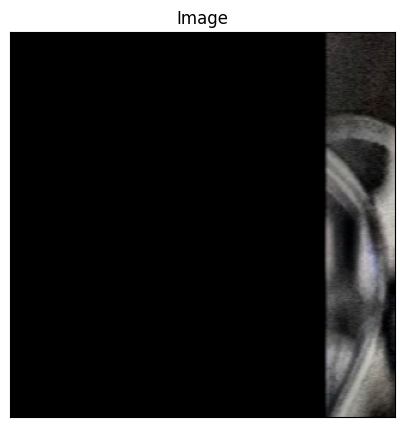

In [17]:

#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    x_train_dir,
    y_train_dir,
    augmentation=get_training_augmentation(),
    classes=CLASSES,
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[1]
    visualize(image=image) #, mask=mask.squeeze(-1))

# Create model and train

In [18]:
%pip install -U segmentation-models-pytorch --quiet


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: /Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [19]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [20]:
ENCODER = 'timm-mobilenetv3_large_100' #'resnet50'  #'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = CLASSES
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' #'mps'

model = smp.FPN(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [21]:
train_dataset = Dataset(
    x_train_dir,
    y_train_dir,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir,
    y_valid_dir,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True) #, num_workers=1) #num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False) #, num_workers=1) #num_workers=4)

In [22]:
from segmentation_models_pytorch import utils

#loss = smp.losses.DiceLoss(mode='multiclass')
loss = utils.losses.BCELoss()

metrics = [
  utils.metrics.IoU(threshold=0.2),
  utils.metrics.Fscore(),
  utils.metrics.Recall(),
  utils.metrics.Precision(),
]

optimizer = torch.optim.Adam([
  dict(params=model.parameters(), lr=0.0001),
])

In [23]:
# epoch runners
train_epoch = utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

In [25]:
# train model

max_score = 0

for i in range(0, 40):

    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')

    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 5/5 [00:02<00:00,  2.04it/s, bce_loss - 0.2794, iou_score - 0.2452, fscore - 0.2624, recall - 0.1675, precision - 0.6379]
Model saved!

Epoch: 1
valid: 100%|██████████| 5/5 [00:02<00:00,  2.08it/s, bce_loss - 0.2688, iou_score - 0.2607, fscore - 0.2366, recall - 0.1424, precision - 0.7426]
Model saved!

Epoch: 2
valid: 100%|██████████| 5/5 [00:02<00:00,  2.00it/s, bce_loss - 0.2569, iou_score - 0.2936, fscore - 0.2396, recall - 0.143, precision - 0.7832] 
Model saved!

Epoch: 3
valid: 100%|██████████| 5/5 [00:02<00:00,  1.99it/s, bce_loss - 0.2606, iou_score - 0.2711, fscore - 0.2181, recall - 0.1328, precision - 0.6499]

Epoch: 4
valid: 100%|██████████| 5/5 [00:02<00:00,  2.03it/s, bce_loss - 0.2549, iou_score - 0.2968, fscore - 0.2215, recall - 0.1322, precision - 0.7318]
Model saved!

Epoch: 5
valid: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s, bce_loss - 0.24, iou_score - 0.3155, fscore - 0.2607, recall - 0.1593, precision - 0.8034]  
Model saved!

# Test best saved model

In [26]:
import torch
# load best saved checkpoint
best_model = torch.load('./best_model.pth')

In [27]:
# create test dataset
test_dataset = Dataset(
    x_test_dir,
    y_test_dir,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

In [28]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 95/95 [00:45<00:00,  2.10it/s, bce_loss - 0.1486, iou_score - 0.5761, fscore - 0.6648, recall - 0.5491, precision - 0.8688]


# Visualize predictions

In [29]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir,
    classes=CLASSES,
)

In [30]:
def visualise_masks(masks_tensor, classes = CLASSES):
    for i in range(len(classes)):
        visualize(mask=masks_tensor[i])


In [44]:
def masks_sum(masks_tensor, classes = CLASSES):
    mask_sum = np.zeros_like(masks_tensor[0])
    for i in range(len(classes)):
        mask_sum += masks_tensor[i]
    return mask_sum

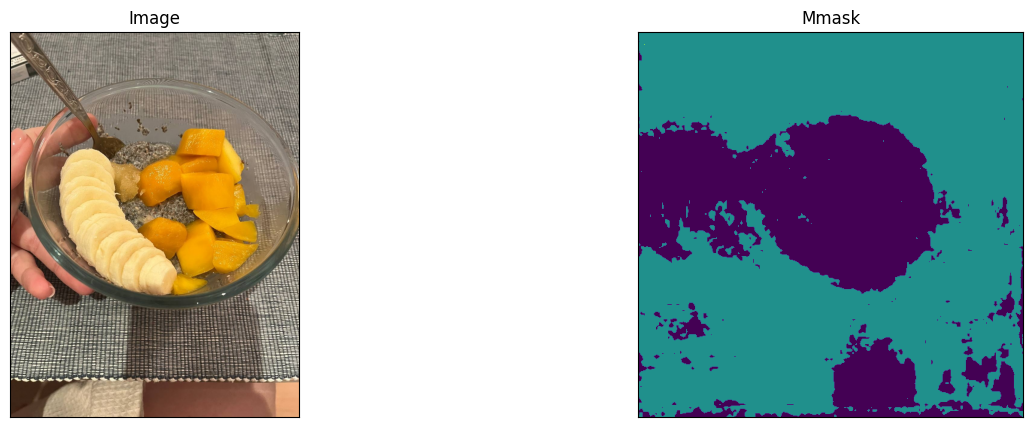

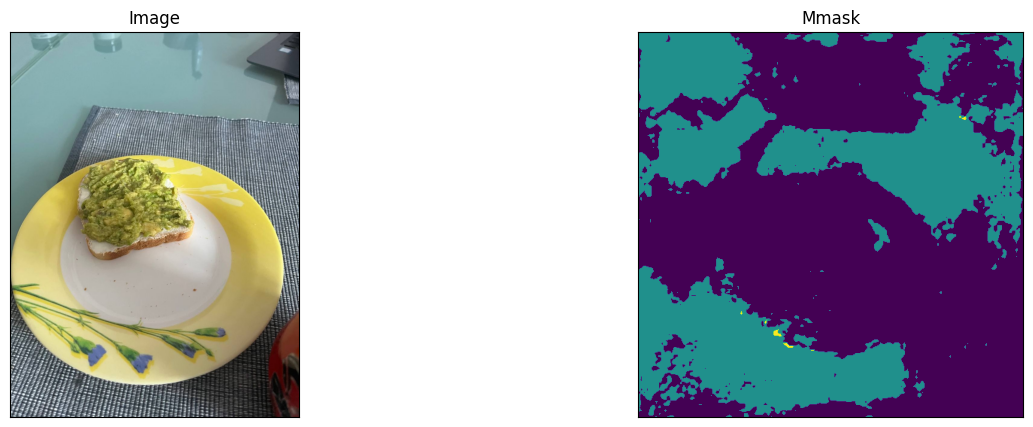

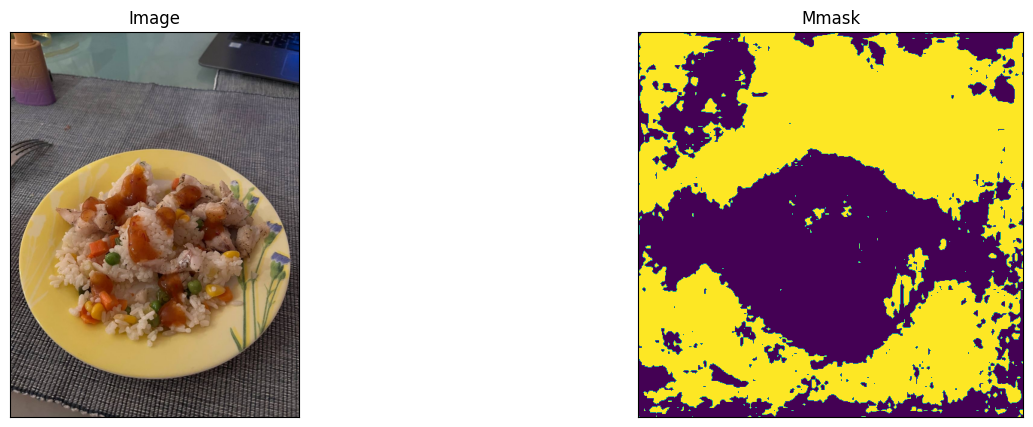

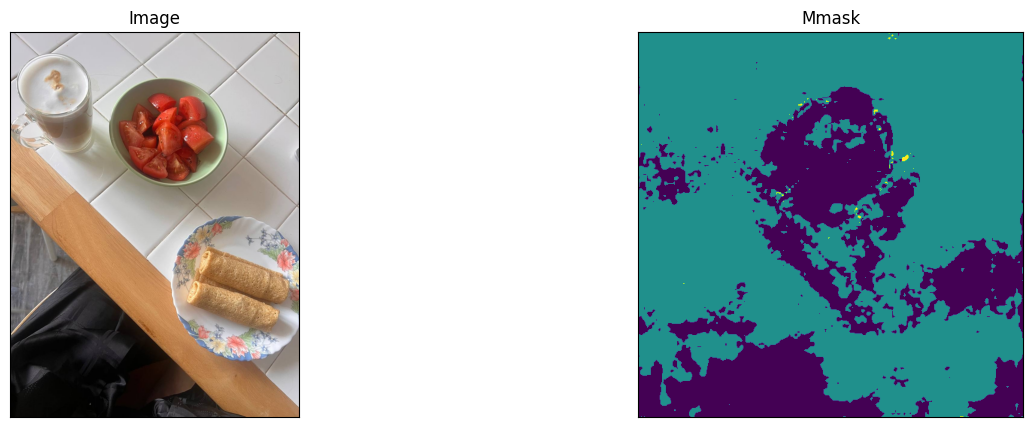

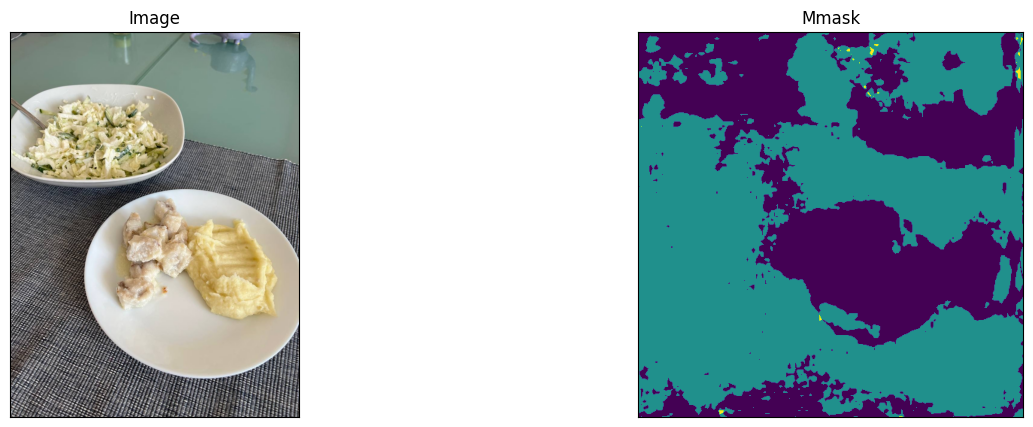

In [49]:
for i in range(5):
    n = np.random.choice(len(test_dataset))

    image_vis = test_dataset_vis[n][0].astype('uint8')
    image_mask = test_dataset_vis[n][1].astype('uint8')
    image, gt_mask = test_dataset[n]

    gt_mask = gt_mask.squeeze()

    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())

    visualize(
        image=image_vis,
        mmask=masks_sum(pr_mask)
    )
    #visualise_masks_sum(pr_mask)

# Model to onnx

In [73]:
import torch
import segmentation_models_pytorch as smp
import timm

model = best_model

model.eval()
model.to(DEVICE)

#test_image = torch.randn(1, 3, 512 , 512, requires_grad=False).half().to(DEVICE)
image, gt_mask = test_dataset[n]
test_image = torch.from_numpy(image).half().to(DEVICE).unsqueeze(0)

orig_out = model(test_image)
orig_out.shape

torch.Size([1, 10, 512, 512])

In [68]:
print(orig_out.type(torch.uint8))

tensor([[[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],

         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],

         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],

         ...,

         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],

         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 

In [74]:
torch_out = torch.onnx.export(
        model,
        test_image,
        'model.onnx',
        training=torch.onnx.TrainingMode.EVAL,
        export_params=True,
        input_names=["input0"],
        output_names=["output0"],
        operator_export_type=torch.onnx.OperatorExportTypes.ONNX
    )

/Users/evakhromeeva/Library/Python/3.9/lib/python/site-packages/segmentation_models_pytorch/base/model.py:16: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if h % output_stride != 0 or w % output_stride != 0:


In [76]:
import onnx

onnx_model = onnx.load('model.onnx')
onnx.checker.check_model(onnx_model, full_check=True)

def onnx_forward(onnx_file, example_input):
    import onnxruntime

    sess_options = onnxruntime.SessionOptions()
    session = onnxruntime.InferenceSession(onnx_file, providers=['TensorrtExecutionProvider'])
    input_name = session.get_inputs()[0].name
    output = session.run([], {input_name: example_input.cpu().numpy()})
    output = output[0]
    return output

import numpy as np
onnx_out = onnx_forward('model.onnx', test_image)
print(onnx_out.astype('uint8'))

[[[[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]

  [[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]

  [[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]

  ...

  [[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]

  [[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]

  [[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]]]


/Users/evakhromeeva/Library/Python/3.9/lib/python/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'TensorrtExecutionProvider' is not in available provider names.Available providers: 'CoreMLExecutionProvider, AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


In [80]:
np.testing.assert_almost_equal(orig_out.type(torch.uint8).data.cpu().numpy(), onnx_out.astype('uint8'), decimal=1)
np.testing.assert_almost_equal(orig_out.type(torch.uint8).data.cpu().numpy(), orig_out.type(torch.uint8).data.cpu().numpy(), decimal=1)